# Imports

In [2]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# import seaborn as sns

import torch
# import open3d as o3d
from collections import defaultdict

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
# from torch_sparse import SparseTensor

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Functions

In [2]:
#error here!!!!!!
def adjacency_matrix_to_triangles(adj_matrix):
    triangles = []
    n = len(adj_matrix)
    for i in range(n):
        for j in range(i + 1, n):
            if adj_matrix[i][j] != 0:
                for k in range(j + 1, n):
                    if adj_matrix[i][k] != 0 and adj_matrix[j][k] != 0:
                        triangles.append((i, j, k))
    return triangles

##################################################################################

#error here!!!!!!
def adjacency_matrix_to_triangles(A):
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("Input adjacency matrix must be a square 2D matrix")

    # Create a 3D matrix
    A_3d = np.repeat(A[:, :, np.newaxis], A.shape[0], axis=2)

    T = np.logical_and(A_3d, np.transpose(A_3d, (2, 0, 1)))
    T = np.logical_and(T, np.transpose(A_3d, (1, 2, 0)))  # Use A_3d instead of A.T
    M, N, P = np.where(T)
    triangles = np.column_stack((M, N, P))
    triangles = np.unique(np.sort(triangles, axis=1), axis=0)
    return triangles

##################################################################################

def edge_index_to_edge_list(edge_index):
    preds_edges = []
    for i,_ in enumerate(edge_index[0]):
        temp = [edge_index[0][i], edge_index[1][i]]
        preds_edges.append(temp)
    preds_edges = np.asarray(preds_edges)
    return preds_edges

##################################################################################

def edges_to_faces(edges):
    face_list = set()
    edge_list = set()
    connections = defaultdict(set)
    for a, b in edges:
        connections[a] |= {b}
        connections[b] |= {a}
        common = connections[a] & connections[b]
        for x in common:
            forward_order = {(x, a),(a, b),(b, x)}
            reverse_order = {(a, x),(x, b),(b, a)}
            if not forward_order & edge_list:
                face_list.add((x, a, b))
                edge_list |= forward_order
            elif not reverse_order & edge_list:
                face_list.add((a, x, b))
                edge_list |= reverse_order
            else:
                face_list.add((b, x, a))
                edge_list.update([(b, x),(x, a),(a, b)])
  
    return np.array(list(face_list))

##################################################################################

def create_triangle_mesh(vertices, triangles):
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)

    return mesh

##################################################################################

def process_data(organ, path, save):
    registered_mesh = []
    mesh = o3d.io.read_triangle_mesh(os.path.join(path, organ))

    vertices_data = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    vertices = torch.from_numpy(vertices_data).double()
    edges = []
    for triangle in triangles:
        edges.append([triangle[0], triangle[1]])
        edges.append([triangle[0], triangle[2]])
        edges.append([triangle[1], triangle[2]])
        
    edges_torch = [[],[]]
    edges =np.unique(np.array(edges), axis=0)
    for edge in edges:
        edges_torch[0].append(edge[0])
        edges_torch[1].append(edge[1])

    edges_torch = torch.from_numpy(np.asarray(edges_torch)).long()

    registered_mesh.append((vertices.type(torch.float32), edges_torch))
    data = Data(x=registered_mesh[0][0], y=registered_mesh[0][1], edge_index=registered_mesh[0][1], num_nodes= len(registered_mesh[0][0]))
    all_edge_index = data.edge_index
    data = train_test_split_edges(data)
    # print(data)

    if(save):
        with open('../data/gae/liver/data', 'wb') as f:
            pkl.dump(data, f)

    return data

##################################################################################

def autoencode_patient(id, organ):    
    torch_geometric.seed_everything(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    path = "../../../../../../vol/aimspace/users/wyo/organ_decimations_ply/2000/"
    model_path = "../models/liver_mesh.ply_global_gae_gat.pt"
    dirs = next(os.walk(path))[1]
    
    path_with_id = os.path.join(path, str(id))
    data = process_data(organ, path_with_id, False)

    x = data.x.to(device)
    y = data.y.to(device)

    model = torch.load(model_path)
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        Z = model.encode(x, y)
        x_hat = model.decode(Z, y)

    temp_preds = y.detach().cpu().numpy()
    x_hat_np = x_hat.detach().cpu().numpy()
    preds = [[], []]

    for i,_ in enumerate(temp_preds[0]):
        if(x_hat_np[i] > 0.5):
            preds[0].append(temp_preds[0][i])
            preds[1].append(temp_preds[1][i])    

    return x, np.asarray(preds), y

##################################################################################

# Model

In [ ]:
############################################################################################

#Iterate over all pairs of consecutive items in a list
def pairwise(iterable):
    """Iterate over all pairs of consecutive items in a list.
    Notes
    -----
        [s0, s1, s2, s3, ...] -> (s0,s1), (s1,s2), (s2, s3), ...
    """
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

############################################################################################

#Generating GNN layers
def get_gnn_layers(num_conv_layers: int, hidden_channels, num_inp_features:int, 
                 gnn_layer, activation=nn.ReLU, normalization=None, dropout = None):
    """Creates GNN layers"""
    layers = nn.ModuleList()

    for i in range(num_conv_layers):
        if i == 0:
            layers.append(gnn_layer(num_inp_features, hidden_channels[i]))
            layers.append(activation())
            if normalization is not None:
                layers.append(normalization(hidden_channels[i]))
        else:
            layers.append(gnn_layer(hidden_channels[i-1], hidden_channels[i]))
            layers.append(activation())
            if normalization is not None:
                layers.append(normalization(hidden_channels[i]))

    return nn.ModuleList(layers)
    
############################################################################################

#Making multilayer perceptron layers 
def get_mlp_layers(channels: list, activation, output_activation=nn.Identity):
    """Define basic multilayered perceptron network."""
    layers = []
    *intermediate_layer_definitions, final_layer_definition = pairwise(channels)

    for in_ch, out_ch in intermediate_layer_definitions:
        intermediate_layer = nn.Linear(in_ch, out_ch)
        layers += [intermediate_layer, activation()]

    layers += [nn.Linear(*final_layer_definition), output_activation()]
    #print('Output activation ',output_activation)
    return nn.Sequential(*layers)
    
    
############################################################################################

#Encoder
class GNN(torch.nn.Module):
    def __init__(self, in_features, hidden_channels, activation, normalization, num_conv_layers=4, layer='gcn',
                 use_input_encoder=True, encoder_features=128, apply_batch_norm=True,
                 apply_dropout_every=True, dropout = 0):
        super(GNN, self).__init__()
        torch.manual_seed(42)
        
        self.fc = torch.nn.ModuleList()
        self.layer_type = layer
        self.use_input_encoder = use_input_encoder
        self.apply_batch_norm = apply_batch_norm
        self.dropout = dropout
        self.normalization_bool = normalization
        self.activation = activation
        self.apply_dropout_every = apply_dropout_every

        if self.normalization_bool:
            self.normalization = LayerNorm
        else:
            self.normalization = None

        if self.use_input_encoder :
            self.input_encoder = get_mlp_layers(
                channels=[in_features, encoder_features],
                activation=nn.ELU,
            )
            in_features = encoder_features

        if layer == 'gcn':
            self.layers = get_gnn_layers(num_conv_layers, hidden_channels, num_inp_features=in_features,
                                        gnn_layer=GCNConv,activation=activation,normalization=self.normalization )
        elif layer == 'sageconv':
            self.layers = get_gnn_layers(num_conv_layers, hidden_channels,in_features,
                                        gnn_layer=SAGEConv,activation=activation,normalization=self.normalization )
        elif layer == 'gat':
            self.layers = get_gnn_layers(num_conv_layers, hidden_channels,in_features,
                                        gnn_layer=GATConv,activation=activation,normalization=self.normalization )        

    def forward(self, x, edge_index):

        if self.use_input_encoder:
            x = self.input_encoder(x)

        if self.normalization is None:
            for i, layer in enumerate(self.layers):
                # Each GCN consists 2 modules GCN -> Activation 
                # GCN send edge index
                if i% 2 == 0:
                    x = layer(x, edge_index)
                else:
                    x = layer(x)

                if self.apply_dropout_every:
                    x = F.dropout(x, p=self.dropout, training=self.training)
        else:
            for i, layer in enumerate(self.layers):
                # Each GCN consists 3 modules GCN -> Activation ->  Normalization 
                # GCN send edge index
                if i% 3 == 0:
                    x = layer(x, edge_index)
                else:
                    x = layer(x)

                if self.apply_dropout_every:
                    x = F.dropout(x, p=self.dropout, training=self.training)        

        return x
    
############################################################################################

# Reading data

In [66]:
with open('../data/gae/liver/x', "rb") as fp:
    x = pkl.load(fp)
fp.close()

with open('../data/gae/liver/z', "rb") as fp:
    z = pkl.load(fp)
fp.close()

with open('../data/gae/liver/x_hat', "rb") as fp:
    x_hat = pkl.load(fp)
fp.close()

with open('../data/gae/liver/preds', "rb") as fp:
    preds_adj = pkl.load(fp)
fp.close()

with open('../data/gae/liver/preds_O', "rb") as fp:
    preds_o = pkl.load(fp)
fp.close()

with open('../data/gae/liver/labels', "rb") as fp:
    labels_adj = pkl.load(fp)
fp.close()

# Outputs

In [67]:
np.all(preds_adj == labels_adj) 

False

In [68]:
x

array([[0.236607, 0.357143, 0.687328],
       [0.236607, 0.364583, 0.678375],
       [0.236607, 0.383929, 0.690083],
       ...,
       [0.598214, 0.535714, 0.741047],
       [0.606027, 0.566964, 0.73416 ],
       [0.607143, 0.545387, 0.734848]], dtype=float32)

In [69]:
with open('../data/gae/liver/data', "rb") as fp:
    data = pkl.load(fp)
fp.close()

data.y.shape

torch.Size([2, 4534])

In [70]:
torch.from_numpy(np.asarray(preds_o)) #before sparse

tensor([[   0,    1,    1,  ..., 1072, 1072, 1072],
        [   2,    0,    2,  ..., 1060, 1064, 1069]])

In [71]:
z

array([[ 0.14073116, -0.06086275, -0.09855279, ..., -0.1725687 ,
        -0.08676751, -0.04885657],
       [ 0.13265345, -0.06063947, -0.09853061, ..., -0.17266183,
        -0.08651856, -0.04893643],
       [ 0.14795879, -0.06089314, -0.09849048, ..., -0.17259616,
        -0.08676959, -0.04881407],
       ...,
       [-0.11610303, -0.0851119 , -0.19114564, ...,  9.230063  ,
        -0.06993339,  2.2482042 ],
       [-0.12720257, -0.07707267, -0.23344775, ..., 18.920456  ,
        -0.06880472,  2.6863194 ],
       [-0.12223478, -0.07978792, -0.21856284, ..., 15.693827  ,
        -0.06856107,  2.575848  ]], dtype=float32)

In [72]:
x_hat

array([0.60020083, 0.5996196 , 0.59983486, ..., 1.        , 1.        ,
       1.        ], dtype=float32)

In [73]:
unique, counts = np.unique(preds_adj, return_counts=True)
dict(zip(unique, counts))

{0.0: 1146794, 1.0: 4535}

In [74]:
unique, counts = np.unique(labels_adj, return_counts=True)
dict(zip(unique, counts))

{0.0: 1146775, 1.0: 4554}

In [75]:
preds_adj

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [76]:
labels_adj

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [77]:
mesh = o3d.io.read_triangle_mesh("../../local_data/decimations/male/1000180/liver_mesh.ply")
og_triangles = np.asarray(mesh.triangles)
og_x = np.asarray(mesh.vertices)
og_triangles.shape

(1999, 3)

In [80]:
preds_edges = []
preds_edges = edge_index_to_edge_list(preds_o)

In [81]:
face_list_np = edges_to_faces(preds_edges)

In [84]:
output = create_triangle_mesh(x, face_list_np)
# output = create_triangle_mesh(og_x, og_triangles)
o3d.visualization.draw_geometries([output], mesh_show_wireframe=True, mesh_show_back_face=True)

# Analysis

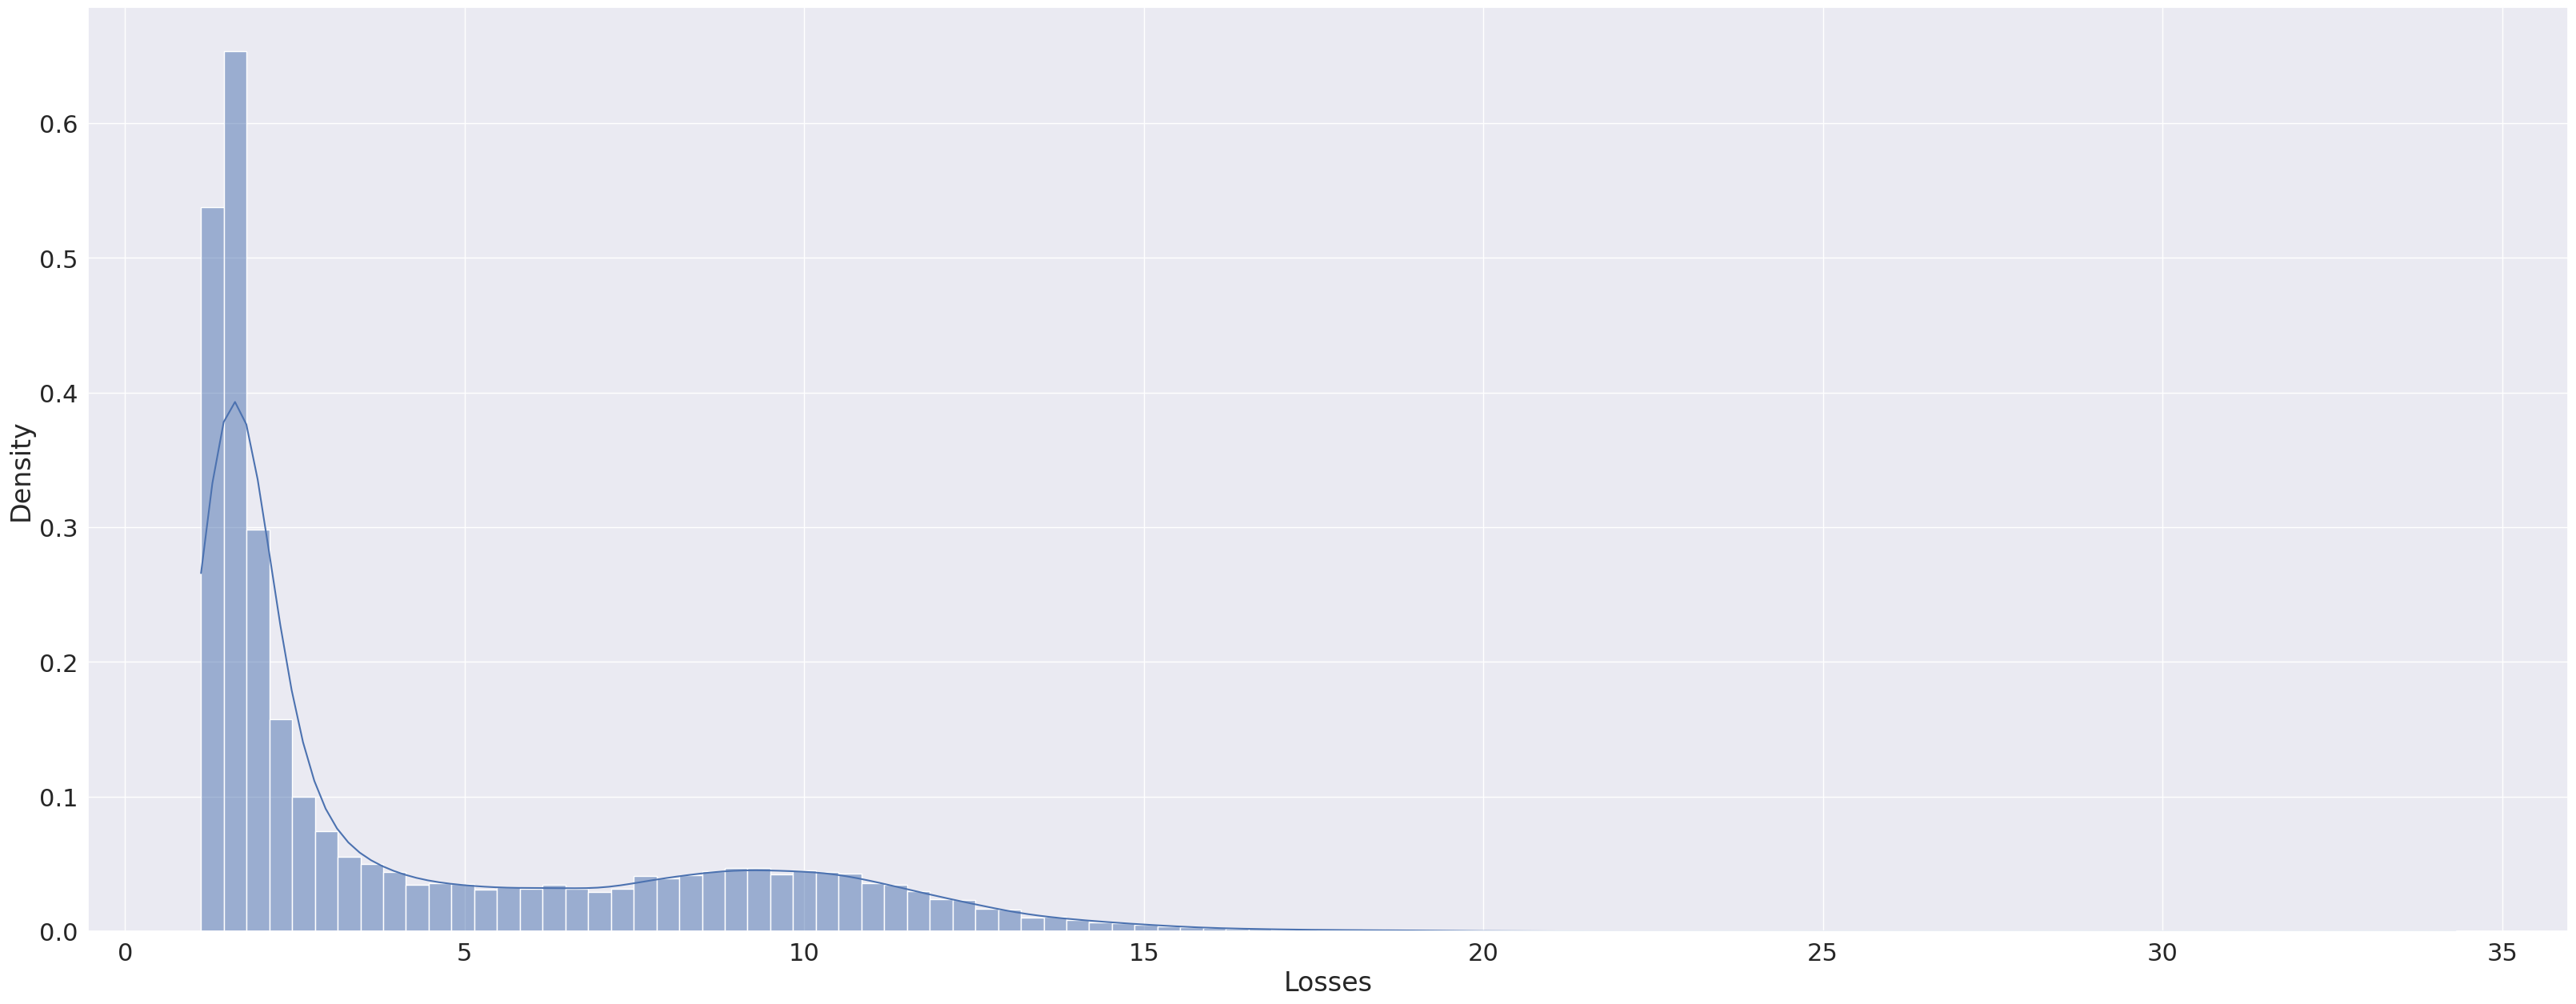

In [31]:
with open('../outputs/liver_gat_losses', "rb") as fp:
    losses = pkl.load(fp)
fp.close()

losses = np.asarray(losses)
losses = losses.astype(np.float64)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (40,15))
df = pd.DataFrame({"losses": losses}) # transform to a dataframe

sns.histplot(df['losses'], kde=True, stat='density', discrete=False)
sns.set(font_scale=2.0)
plt.xlabel('Losses')
plt.ylabel('Density')
# plt.title('Distribution Curve')

plt.show()

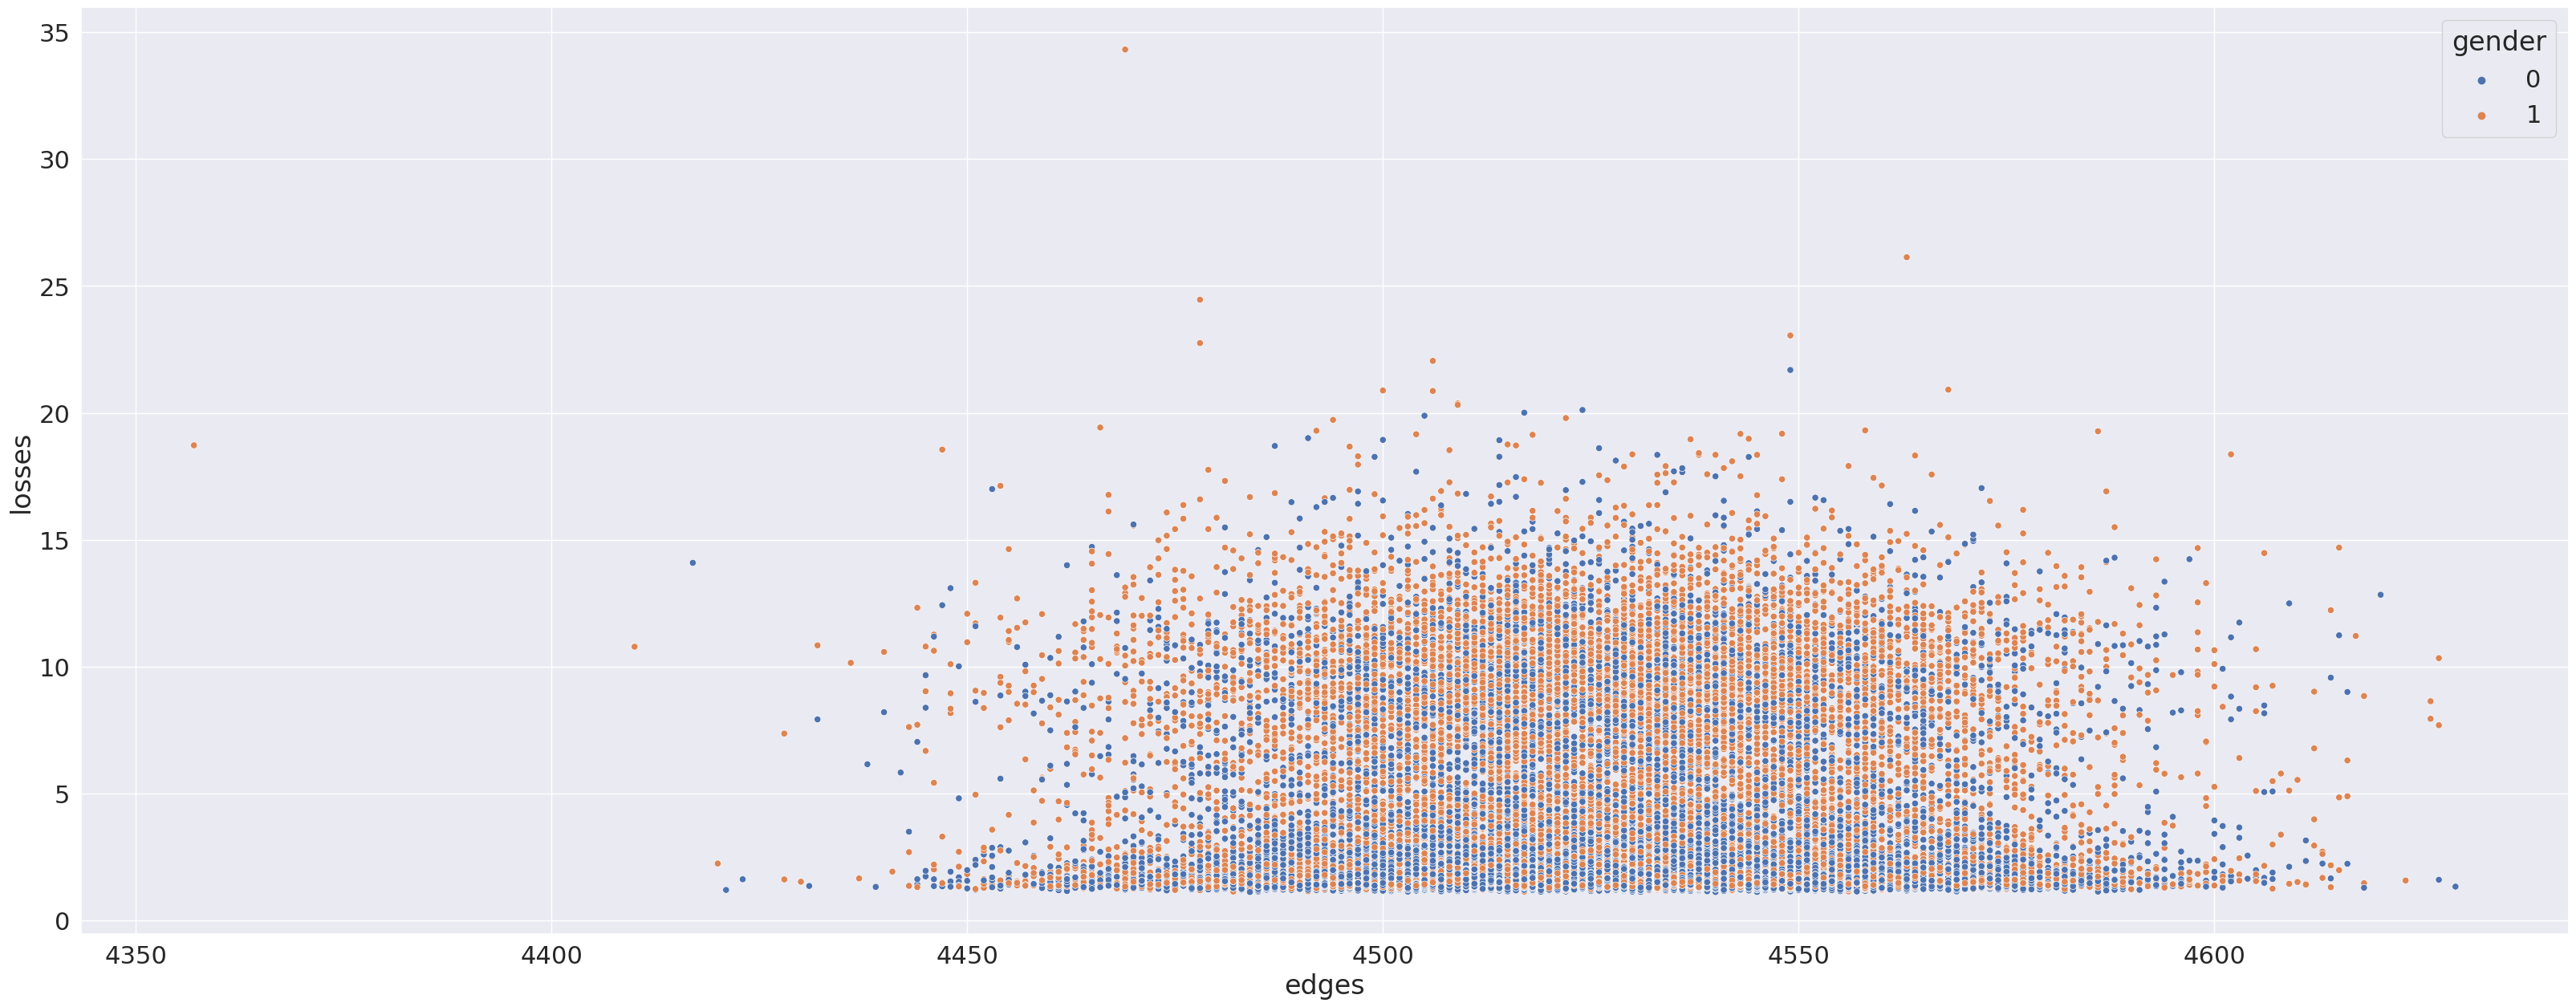

         losses   edges         id  gender
4933  34.314503  4469.0  3655108.0       1


In [34]:
with open('../outputs/liver_gat_losses', "rb") as fp:
    losses = pkl.load(fp)
fp.close()
with open('../outputs/liver_gat_edges_count', "rb") as fp:
    edges_counts = pkl.load(fp)
fp.close()

with open('../outputs/liver_gat_ids', "rb") as fp:
    ids = pkl.load(fp)
fp.close()


losses = np.asarray(losses)
losses = losses.astype(np.float64)
edges_counts = np.asarray(edges_counts)
edges_counts = edges_counts.astype(np.float64)
ids = np.asarray(ids)
ids = ids.astype(np.float64)
df = pd.DataFrame({"losses": losses, "edges": edges_counts, "id": ids, "gender": 1}) # transform to a dataframe

female_ids = np.loadtxt("../data/female_mesh_ids.csv")
for index, row in df.iterrows():
    if(row.id in female_ids):
        df.loc[df['id'] == row.id, 'gender'] = 0

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (40,15))

sns.scatterplot(data=df, x="edges", y="losses", hue="gender")

plt.show()

row = df[df['losses'] > 30]
print(row)

/tmp/ipykernel_2309038/3678684059.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  losses = losses.astype(np.float)


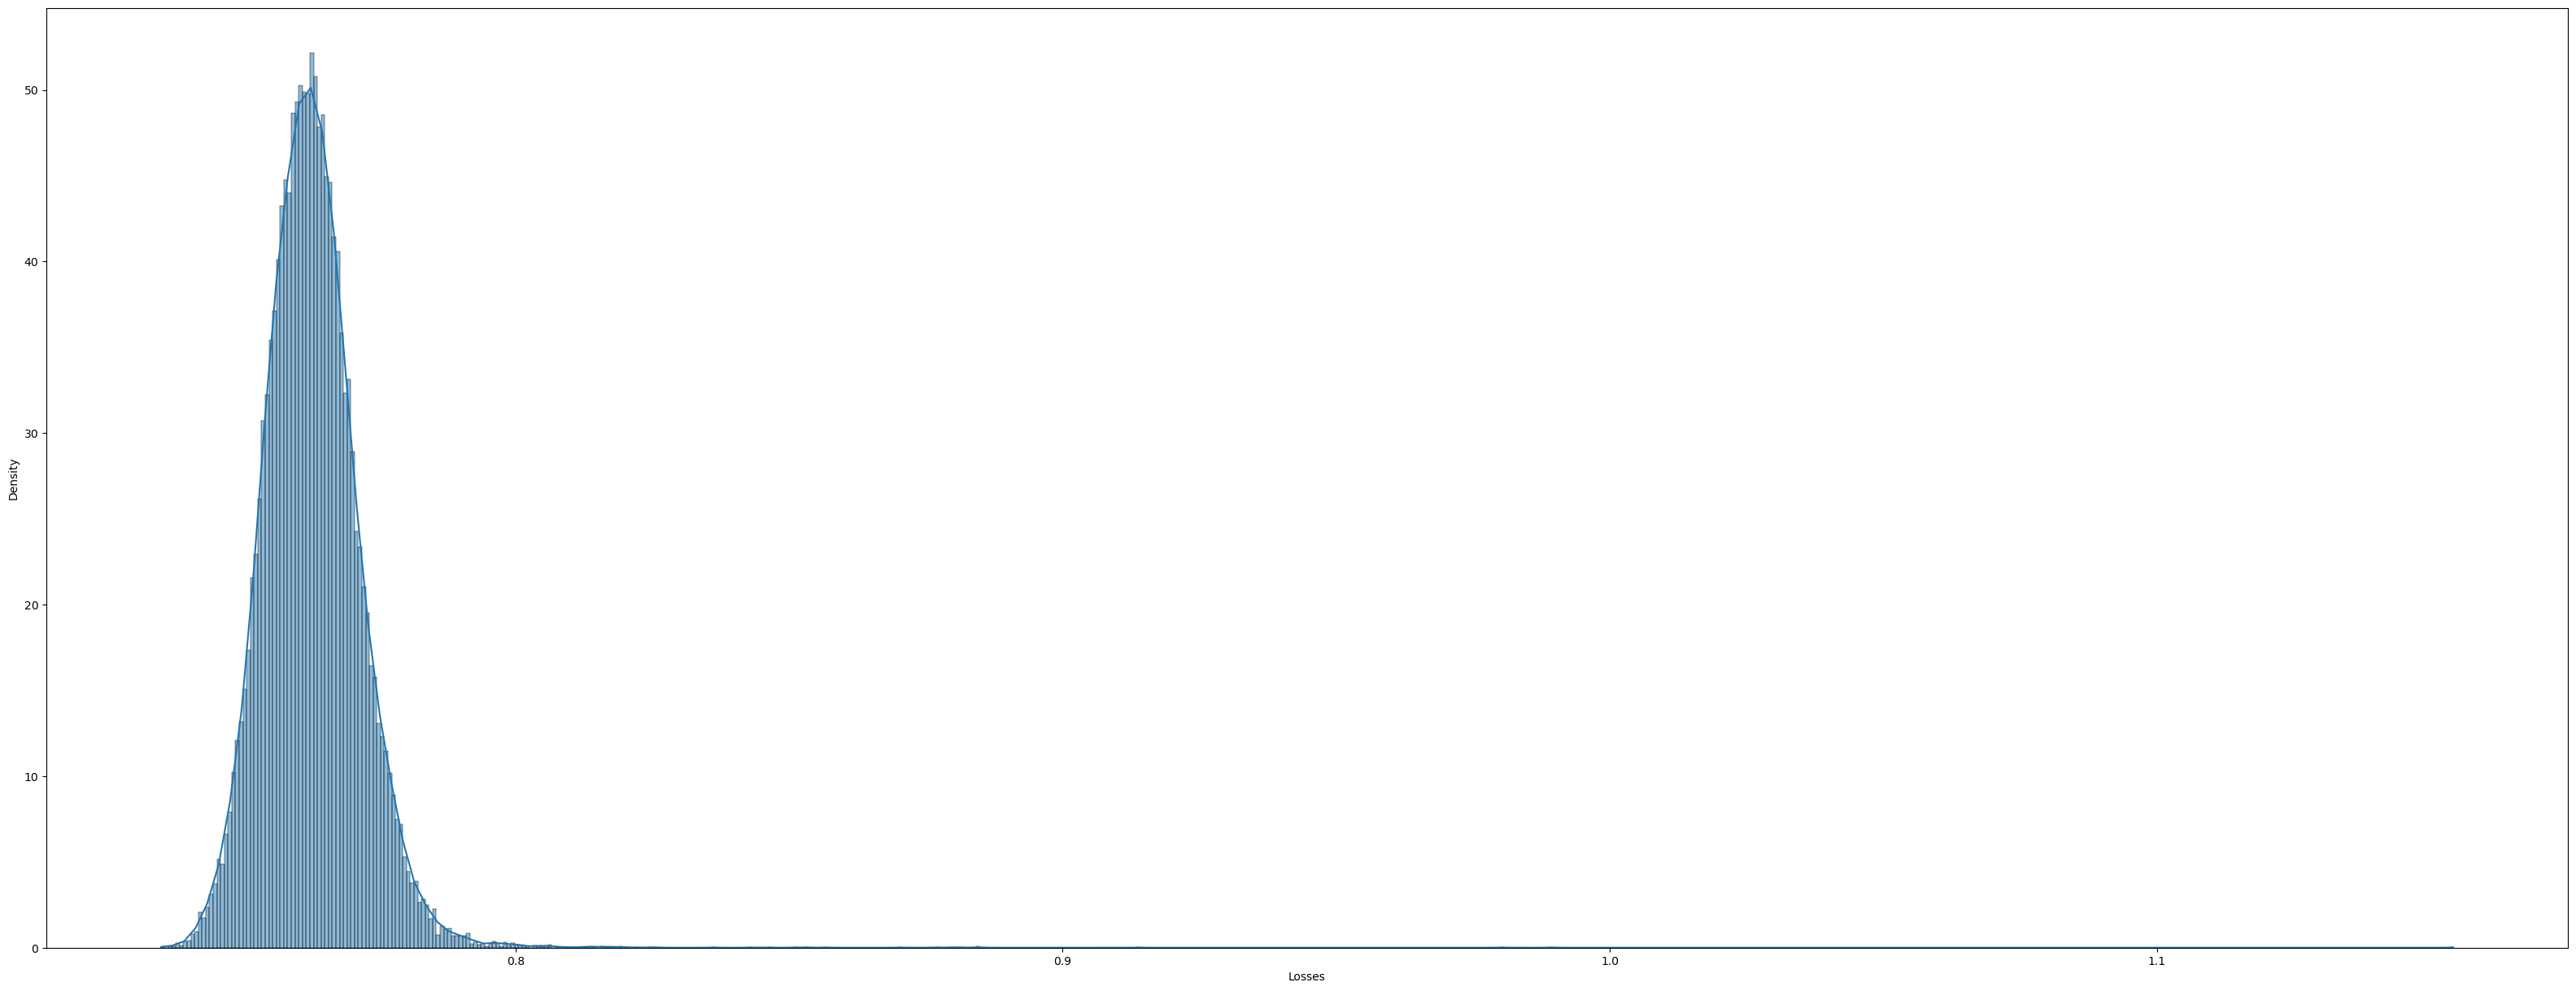

In [6]:
with open('../outputs/liver_global_gat_losses', "rb") as fp:
    losses = pkl.load(fp)
fp.close()

losses = np.asarray(losses)
losses = losses.astype(np.float64)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (40,15))
df = pd.DataFrame({"losses": losses}) # transform to a dataframe

sns.histplot(df['losses'], kde=True, stat='density', discrete=False)
sns.set(font_scale=2.0)
plt.xlabel('Losses')
plt.ylabel('Density')
# plt.title('Distribution Curve')

plt.show()

In [9]:
np.max(losses)

1.1541303396224976

In [10]:
np.min(losses)

0.7352235913276672

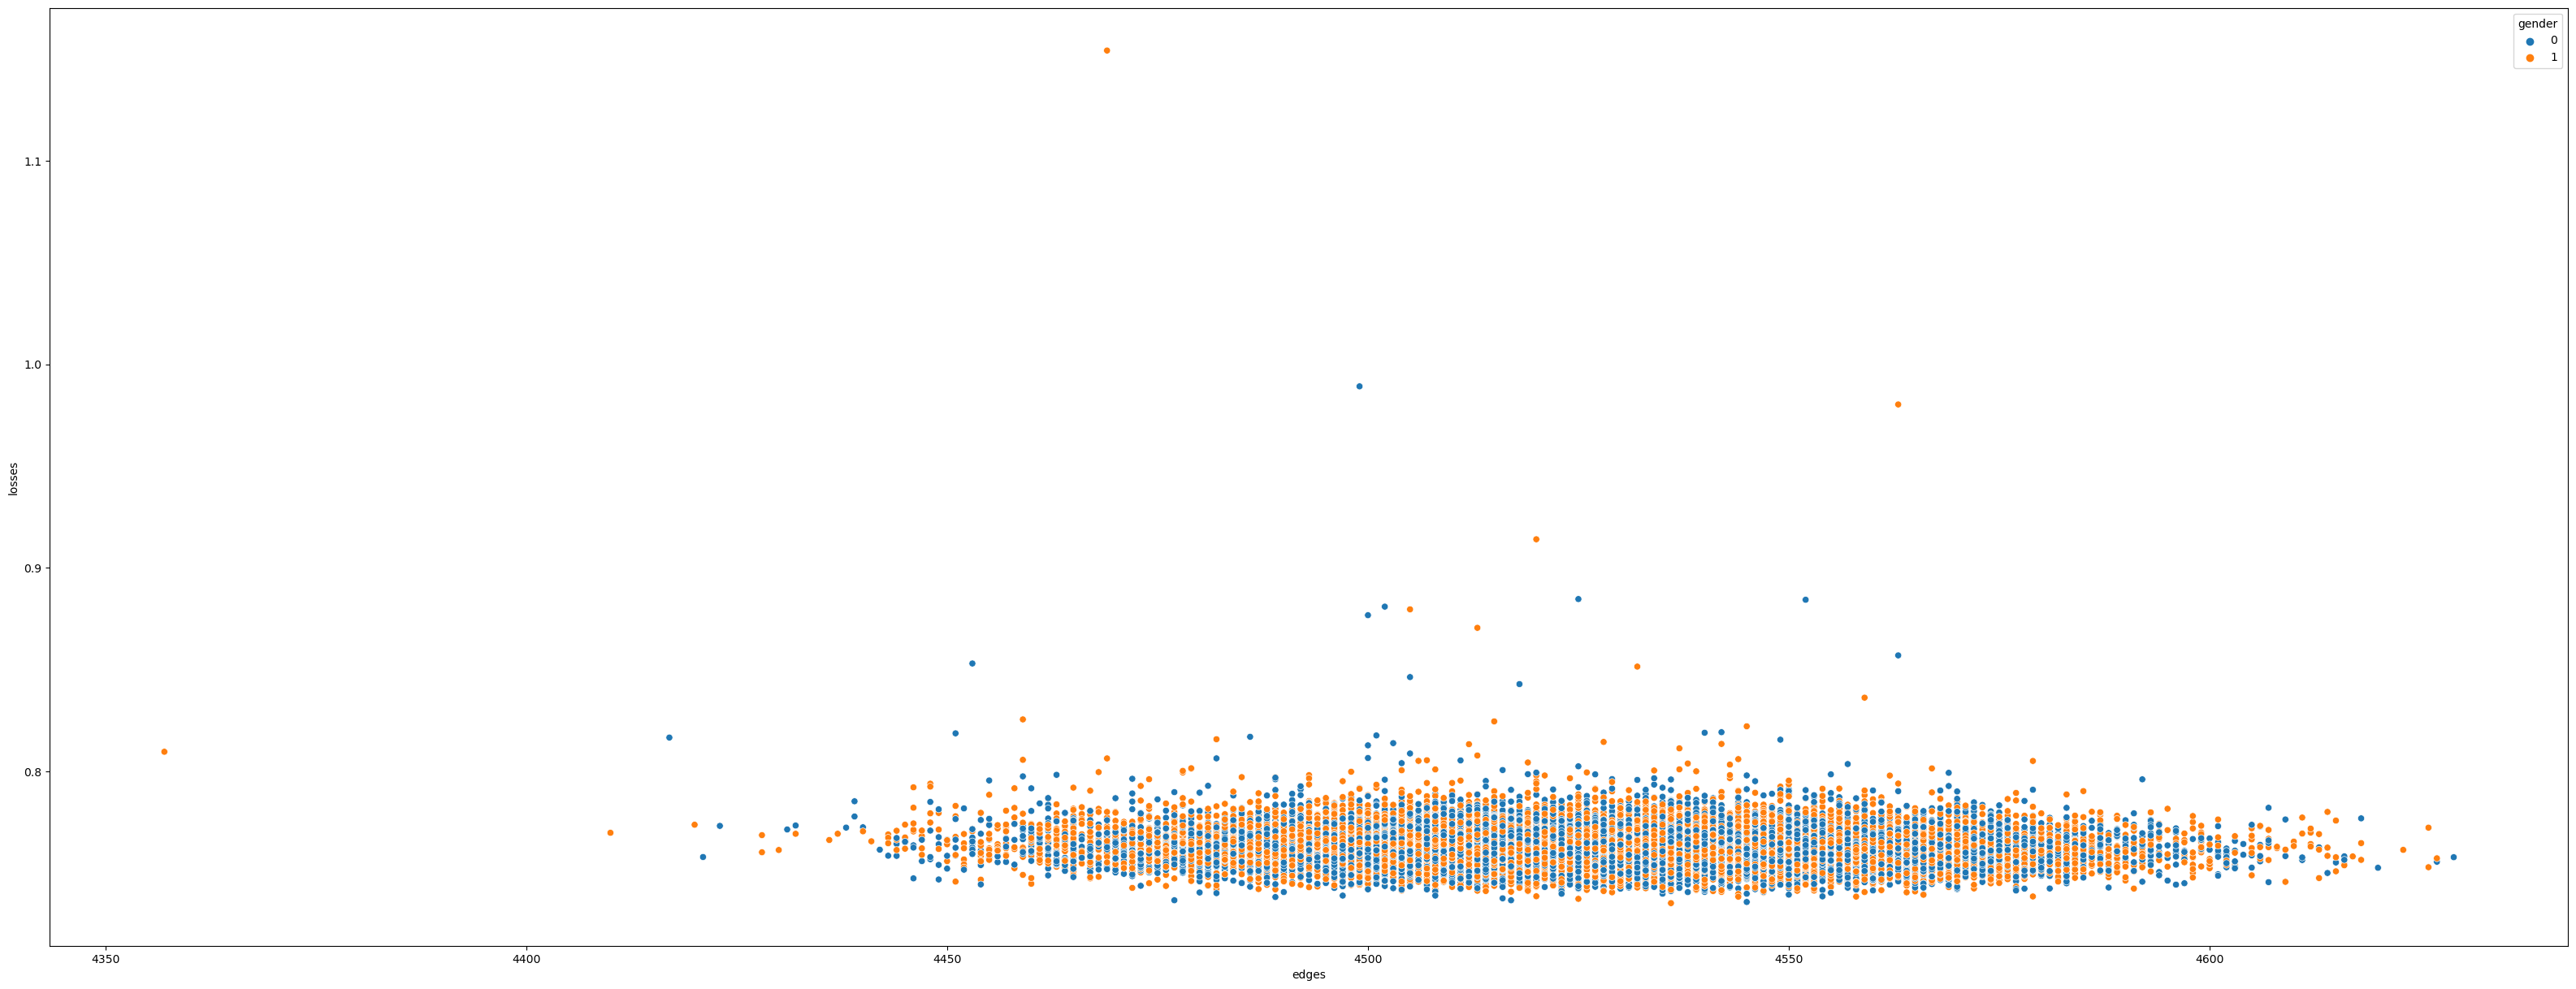

       losses   edges         id  gender
4933  1.15413  4469.0  3655108.0       1


In [4]:
with open('../outputs/liver_global_gat_losses', "rb") as fp:
    losses = pkl.load(fp)
fp.close()
with open('../outputs/liver_global_gat_edges_count', "rb") as fp:
    edges_counts = pkl.load(fp)
fp.close()

with open('../outputs/liver_global_gat_ids', "rb") as fp:
    ids = pkl.load(fp)
fp.close()


losses = np.asarray(losses)
losses = losses.astype(np.float64)
edges_counts = np.asarray(edges_counts)
edges_counts = edges_counts.astype(np.float64)
ids = np.asarray(ids)
ids = ids.astype(np.float64)
df = pd.DataFrame({"losses": losses, "edges": edges_counts, "id": ids, "gender": 1}) # transform to a dataframe

female_ids = np.loadtxt("../data/female_mesh_ids.csv")
for index, row in df.iterrows():
    if(row.id in female_ids):
        df.loc[df['id'] == row.id, 'gender'] = 0

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (40,15))

sns.scatterplot(data=df, x="edges", y="losses", hue="gender")

plt.show()

row = df[df['losses'] > 1]
print(row)

In [5]:
row = df[df['losses'] > 0.9] 
print(row)

         losses   edges         id  gender
2378   0.980235  4563.0  3905350.0       1
4933   1.154130  4469.0  3655108.0       1
6838   0.913995  4520.0  4701181.0       1
18737  0.989127  4499.0  2977377.0       0


In [6]:
row = df[df['losses'] == 0.7352235913276672]
print(row)

         losses   edges         id  gender
21407  0.735224  4536.0  4876166.0       1


# Original meshes Visuals

In [ ]:
mesh = o3d.io.read_triangle_mesh("../../local_data/server_mesh_atlases/2000/female/avg/right_kidney_mesh.ply")
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)

In [ ]:
mesh = o3d.io.read_triangle_mesh("../../local_data/organ_decimations_ply/2000/4701181/liver_mesh.ply") #3655108, 2977377, 3905350, 4701181
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)

In [ ]:
mesh = o3d.io.read_triangle_mesh("../../local_data/organ_decimations_ply/2000/4876166/liver_mesh.ply") 
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)

# Outputs Visuals

In [ ]:
x, predicted_edges, y = autoencode_patient(3655108, "liver_mesh.ply") #worst: 3655108, best: 4876166
edges = edge_index_to_edge_list(predicted_edges)
faces = edges_to_faces(edges)
output = create_triangle_mesh(x, faces)

In [ ]:
o3d.visualization.draw_geometries([output], mesh_show_wireframe=True, mesh_show_back_face=True)

In [92]:
mesh = o3d.io.read_triangle_mesh("../outputs/gae_4876166_liver_mesh.ply") 
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)

In [93]:
mesh = o3d.io.read_triangle_mesh("../../local_data/organ_decimations_ply/2000/4876166/liver_mesh.ply") 
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)